In [1]:
import yfinance as yf
import pandas as pd
import pprint
from tqdm import tqdm
import matplotlib.pyplot as plot
import seaborn as sns
import pickle

## Importazione della lista di stock supportata da revolut

In [2]:
stocks_list = pd.read_csv('Stock_list.csv', sep=';')
stocks = ''
for item in stocks_list['Ticker']:
    stocks = stocks + ' ' + str(item)

### Scaricamento dei dati di storico delle aziende

In [3]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = stocks,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "2y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'column',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = False,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = False,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%***********************]  791 of 791 completed

3 Failed downloads:
- AABA: No data found, symbol may be delisted
- BID: No data found, symbol may be delisted
- BMYRT: No data found, symbol may be delisted


### Download dei dati delle aziende

In [ ]:
#ff = pd.DataFrame(yf.Ticker('MSFT').info)
#to_del = []
#
#for company in tqdm(pos_perf.index):
#    try:
#        ff = ff.append(yf.Ticker(company).info, ignore_index=True).fillna(0)
#    except Exception as e:
#        print(company)
#        to_del.append(company)
#        print(e)
#        continue

## Salvataggio dei dati scaricati

In [4]:
#data.to_pickle('dataset.pkl')

In [2]:
data = pd.read_pickle('dataset.pkl')

In [42]:
ff = pd.read_pickle('descriptions.pkl')

In [16]:
#pd.DataFrame(to_del, columns=['To_del']).to_csv('info unavaliable.csv')

In [3]:
#missing = pd.read_csv('info unavaliable.csv')

### Filtro sulle date

In [4]:
def extract_performance(df):
    return ((df['Close'].iloc[df['Close'].shape[0]-1] - df['Close'].iloc[0]))/(df['Close'].iloc[0])*100

def filter_data(df, data_init, data_final):
    return df[data_init : data_final]

def performance(df, value):
    return df[df > value].sort_values()

In [5]:
data.fillna(value=0, inplace=True)

In [6]:
init = data.index[0]
pre_covid = '2020-01-31'
list_dates = pd.date_range(start='2018-05-01', end= '2020-02-01', freq='M')
post_covid = data.index[-1]

In [30]:
## Performance pre covid

for date in list_dates:
    try:
        pre = filter_data(data, date, date + pd.DateOffset(months=1))
        per = extract_performance(pre)
        pos_perf = performance(per, -80)
        pos_perf = pos_perf[pos_perf<1000]
        clean = ff.copy()
        column_list = list(clean.columns[0:14].values)
        column_list.append('symbol')
        clean = clean[column_list]
        clean.drop(columns=['phone','companyOfficers', 'zip', 'longBusinessSummary','address1', 'address1', 'fax', 'maxAge','website'], inplace=True)
        clean['percentage_1y'] = clean['symbol'].map(dict(pos_perf), na_action='ignore')
        clean.set_index('symbol',inplace=True, drop=True)
        clean.fillna(0, inplace=True)
        clean.replace(0,'Unknown',inplace=True)
        clean.replace('','Unknown',inplace=True)
        clean.fullTimeEmployees.replace('Unknown',0, inplace=True)
        clean.percentage_1y.replace('Unknown',0, inplace=True)
        plot.figure(figsize=(30,15))
        im = sns.scatterplot(data=clean.sort_values(by='percentage_1y'), x=clean.index, y='percentage_1y', hue='sector') 
        im.set(ylim=(-100, 180))
        plot.savefig('Raggruppamento per value_' + str(date) + '.png')
        #plot.savefig('Raggruppamento per settore.png')
        plot.close()
        plot.figure(figsize=(30,12))
        im = sns.scatterplot(data=clean.sort_values(by='sector'), x=clean.index, y='percentage_1y', hue='sector')
        im.set(ylim=(-100, 180))
        plot.savefig('Raggruppamento per settore' + str(date) + '.png')
        #plot.savefig('Raggruppamento per settore1.png')
        plot.close()
        centroids = clean[['sector','percentage_1y']].pivot_table(values='percentage_1y', columns='sector', aggfunc=('mean', 'count'))
        centroids = centroids.T
        plot.figure(figsize=(15, 10))
        im = sns.scatterplot(data=centroids.sort_values(by='mean'), x=centroids.index, y='mean', hue=centroids.index, size='count', sizes=(40, 500))
        im.set(ylim=(-40, 40))
        plot.savefig('Centroidi per settore_' + str(date) + '.png')
        #plot.savefig('Raggruppamento per settore1.png')
        plot.close()
    except Exception as e:
        print(e)
        continue

In [227]:
weekly = data['Close']

In [228]:
weekly['day'] = data.index.to_series().dt.dayofweek

<ipython-input-228-928fcbba068f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly['day'] = data.index.to_series().dt.dayofweek


In [229]:
weekly = weekly[weekly['day']==0]
data_delta = weekly - weekly.shift(-1)

In [230]:
data_delta = data_delta[:'2020-02-01']

In [231]:
data_delta.drop(columns='day', inplace=True)

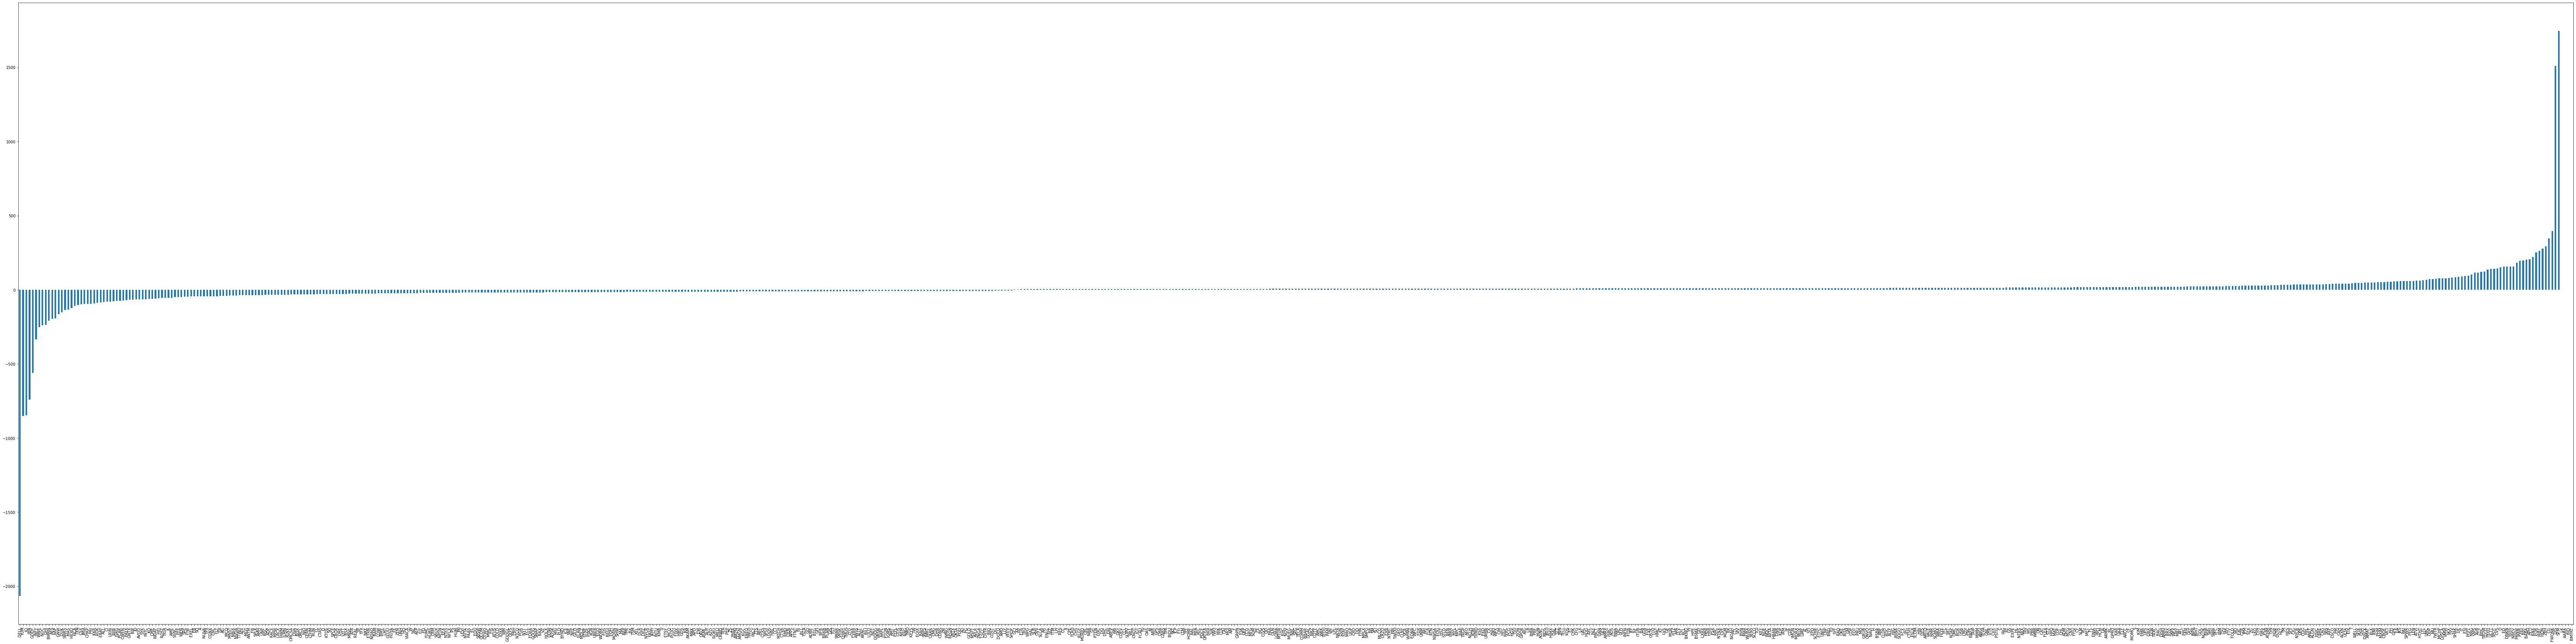

In [75]:
(data_delta.describe().loc['std']/data_delta.describe().loc['mean']).sort_values().plot.bar(figsize=(120,30))
plot.savefig('Stds.png')
plot.savefig('Stds.svg')

In [76]:
plot.close()

In [232]:
data_delta.describe()

,A,AA,AABA,AAL,AAP,AAPL,ABBV,ABEV,ABT,ADBE,...,ZBRA,ZEN,ZG,ZION,ZM,ZNGA,ZNH,ZS,ZTO,ZTS
count,84.000000,84.000000,84.0,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,...,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,-0.175714,0.479881,0.0,0.181905,-0.196548,-1.470238,0.206309,0.025357,-0.330238,-1.512024,...,-1.250833,-0.402976,0.107262,0.111905,-1.043571,-0.026071,0.310952,-0.347262,-0.065000,-0.635357
std,2.622512,1.882644,0.0,1.826325,5.579094,7.676474,3.255364,0.215090,2.226056,10.373258,...,9.967614,4.280494,3.237079,1.876178,8.664121,0.213857,2.730882,4.613739,0.936715,3.132796
min,-6.639999,-4.119999,0.0,-4.860001,-16.000000,-19.279999,-8.029999,-0.630000,-6.770004,-24.269989,...,-26.819992,-13.459999,-8.990002,-4.480000,-65.699997,-0.640000,-8.919998,-12.040001,-2.830000,-11.389999
25%,-1.857500,-0.752501,0.0,-0.957500,-4.157494,-5.407501,-1.610003,-0.100000,-1.432500,-7.312504,...,-7.082489,-2.872500,-1.499999,-1.022501,-0.102499,-0.140000,-1.030001,-2.640002,-0.622500,-1.880001
50%,-0.285002,0.430000,0.0,0.315001,-0.134995,-2.489998,0.244999,0.030000,-0.199997,-2.839996,...,-1.450005,-0.815001,-0.059999,-0.064999,0.000000,-0.045000,0.140000,-0.555000,-0.070001,-0.524998
75%,1.462505,1.474999,0.0,1.195001,3.339996,1.730000,1.949999,0.195000,0.900000,2.697495,...,4.292503,2.049995,1.807499,0.980001,0.000000,0.062500,1.260000,1.542500,0.322500,0.699999
max,5.510002,6.079998,0.0,5.810001,11.720001,22.759995,7.620003,0.490000,5.389999,26.860016,...,25.350006,16.380005,11.580002,6.290001,13.110001,0.840000,10.110001,14.400002,2.400000,7.730003


In [233]:
ssv = (data_delta.describe().loc['std']/data_delta.describe().loc['mean']).sort_values()
ssv.to_csv('std.csv', sep=';', decimal=',')

In [234]:
ssv = pd.DataFrame(ssv)

In [235]:
ssv['sector'] = pd.Series(ssv.index.values).map(dict(ff[['symbol','sector']].values), na_action='ignore').values

In [236]:
ssv = ssv.dropna().replace(0, 'Unknown').sort_values('sector')#.plot.bar(figsize=(40,10))
ssv.rename(columns = {0:'std'}, inplace=True)

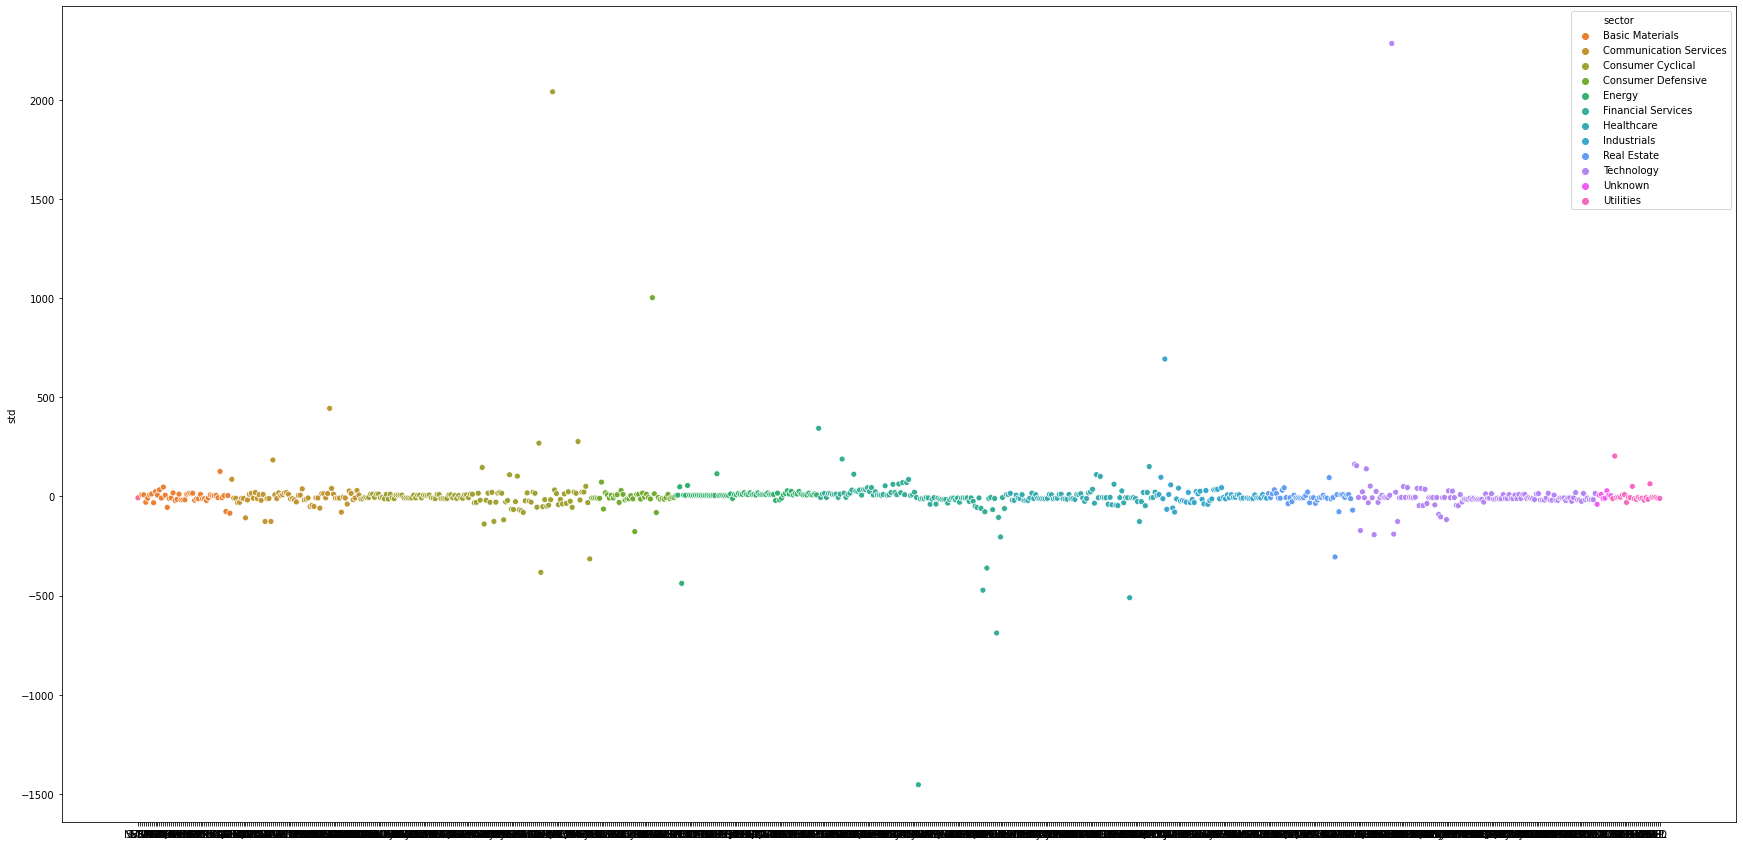

In [239]:
plot.figure(figsize=(30,15))
sns.scatterplot(data=ssv, x=ssv.index, y='std', hue='sector') 
plot.savefig('STD_sector_aligned.png')

In [4]:
def get_stock_data(df, stocksimbol):
    df = df.xs(stocksimbol, axis=1, level = 1, drop_level=True)
    df.drop(columns='Close', inplace=True)
    df.rename(columns = {'Adj Close':'Close'}, inplace=True)
    df.columns = df.columns.str.lower()
    return df

In [ ]:
import pandas as pd
from stockstats import StockDataFrame as Sdf

data = pd.read_pickle('dataset.pkl')

score = []
name = []
diff = []

for symbol in tqdm(data.columns.get_level_values(1).unique().values):
    try:
        stock  = Sdf.retype(get_stock_data(data, symbol))

        signal = stock['macds']        # Your signal line
        macd   = stock['macd']         # The MACD that need to cross the signal line
        #                                              to give you a Buy/Sell signal
        listLongShort = ["No data"]    # Since you need at least two days in the for loop

        for i in range(1, len(signal)):
            #                          # If the MACD crosses the signal line upward
            if macd[i] > signal[i] and macd[i - 1] <= signal[i - 1]:
                listLongShort.append(1)
            #                          # The other way around
            elif macd[i] < signal[i] and macd[i - 1] >= signal[i - 1]:
                listLongShort.append(-1)
            #                          # Do nothing if not crossed
            else:
                listLongShort.append(0)

        stock['Advice'] = listLongShort
        # The advice column means "Buy/Sell/Hold" at the end of this day or
        #  at the beginning of the next day, since the market will be closed
        stock['Advice'][0] = 0
        #print(stock[stock['Advice']!=0])
        if stock[stock['Advice']!=0]['advice'][-1] == 1:
            stock['Advice'][-1] = -1

        gain = stock['close']*stock['Advice']*(-1)
        delta = (stock['close'][-1]-stock['close'][0])/(stock['close'][0])
        #stock['gain'] = gain
        #print(gain.sum()/(stock['close'][-1]-stock['close'][0]))
        
        score.append(gain.sum()/(stock['close'][0]))
        name.append(symbol)
        diff.append(delta)
    except:
        continue

diff = pd.DataFrame(diff, index=name)
scores = pd.DataFrame(score, index=name)
scores.rename(columns={0:'Performance'}, inplace=True)

In [43]:
ff = ff[['symbol', 'sector']]
ff.set_index('symbol', inplace=True)
scores = pd.merge(ff, scores, left_index=True, right_index=True)
scores = pd.merge(scores, diff, left_index=True, right_index=True)
scores['sector'].replace(0, 'Unknown', inplace=True)

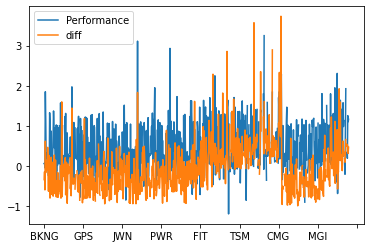

In [46]:
scores.rename(columns={0:'diff'}, inplace=True)
scores[['Performance','diff']].plot()

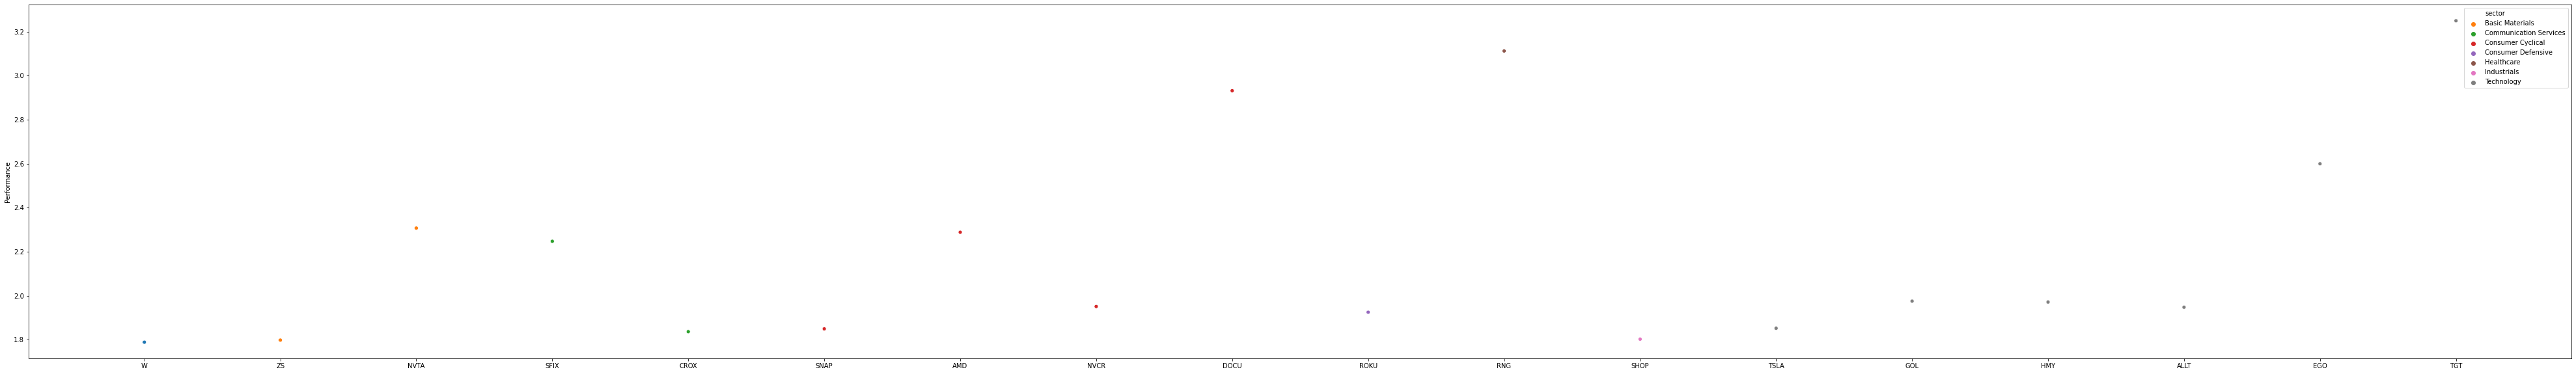

In [47]:
fig = plot.figure(figsize=(70, 10))
filtered = scores[scores['Performance']>1.75]
sns.scatterplot(data=filtered.sort_values(by='sector'), x=filtered.index, y='Performance', hue='sector')
plot.savefig('performance_sector.svg')

In [48]:
filtered.sort_values(by='Performance', ascending=False).to_csv('best_performers_MACD.csv', sep=';', decimal=',')

In [49]:
ff.query("symbol in " + str(list(filtered.index.values))).to_csv('Best_performer_MACD_values.csv', sep=';', decimal=',')

In [ ]:
import pandas as pd
from stockstats import StockDataFrame as Sdf

data = pd.read_pickle('dataset.pkl')

score = []
name = []

for company in filtered.index.values:
    stock  = Sdf.retype(get_stock_data(data, company))

    signal = stock['macds']        # Your signal line
    macd   = stock['macd']         # The MACD that need to cross the signal line
    #                                              to give you a Buy/Sell signal
    listLongShort = ["No data"]    # Since you need at least two days in the for loop

    for i in range(1, len(signal)):
        #                          # If the MACD crosses the signal line upward
        if macd[i] > signal[i] and macd[i - 1] <= signal[i - 1]:
            listLongShort.append(1)
        #                          # The other way around
        elif macd[i] < signal[i] and macd[i - 1] >= signal[i - 1]:
            listLongShort.append(-1)
        #                          # Do nothing if not crossed
        else:
            listLongShort.append(0)

    stock['Advice'] = listLongShort

    # The advice column means "Buy/Sell/Hold" at the end of this day or
    #  at the beginning of the next day, since the market will be closed
    stock['Advice'][0] = 0

    if stock[stock['Advice']!=0]['advice'][-1] == 1:
        stock['Advice'][-1] = -1


    #print(stock[stock['Advice']!=0]['advice'][-1])


    gain = stock['close']*stock['Advice']*(-1)
    stock['gain'] = gain
    #score.append(gain.sum()/(stock['close'][-1]-stock['close'][0]))
    #name.append(symbol)
    stock['Advice']=stock['Advice']*100
    stock.drop(columns=['volume', 'gain']).plot(figsize=(30,10))
    plot.title(str(round(gain.sum()*100/(stock['close'][0]))) + '%')
    plot.savefig(str(company) + '_test.png')
    plot.close()

In [54]:
filtered['delta'] = filtered['Performance'] - filtered['diff']

<ipython-input-54-1cea12062c1d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['delta'] = filtered['Performance'] - filtered['diff']


In [61]:
filtered.sort_values(by='delta', ascending=False).to_csv('best_performers_MACD.csv', sep=';', decimal=',')

In [69]:
fig, ax = plot.subplots(figsize=(10,5))
filtered.sort_values(by='delta', ascending=False).drop(columns='diff').plot(figsize=(10,5), ax=ax)
filtered.sort_values(by='delta', ascending=False)['diff'].plot.bar(figsize=(10,5), ax=ax)
plot.savefig('decision_making.svg')
plot.close()